In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Wprowadzenie:

Celem algorytmu jest wyznaczenie harmonogramu optymalnej pracy zasobnika bateryjnego,
tak aby zminimalizować całkowity koszt funkcjonowania mikrosieci, na który wpływają:

a) dynamiczne ceny zakupu i sprzedaży energii (wyrażone prognozami za 12 okresów agregacji)    

b) podwyższona cenowo taryfą określającą dodatkowy koszt za ponadumowny pobór energii elektrycznej, wyrażony bilansem energetycznym uzyskanym na podstawie prognozy zużycia energii elektrycznej oraz prognozy jej produkcji ze źródła PV

## Prognozy cen zakupu oraz sprzedaży energii elektrycznej:

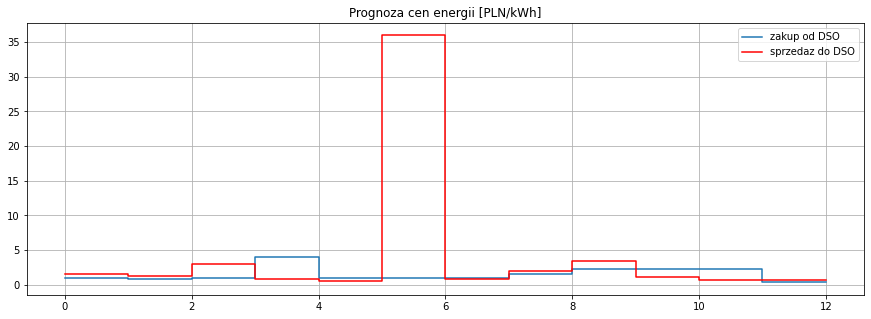

In [2]:
#Liczba danych w określonym czasie agregacji (np. 10 min)
x=np.array([0,1,2,3,4,5,6,7,8,9,10,11,12])

# Ceny energii elektrycznej od dostawcy energii (DSO)
cDSOz = np.array([1,1, 0.8, 1, 4, 1, 1, 1, 1.58, 2.2, 2.2, 2.2, 0.3])  # cena PLN za zakup od DSO 1 kWh energii
cDSOs = np.array([1.5,1.5, 1.2, 3, 0.8, 0.5, 36, 0.8, 1.9, 3.4, 1.05, 0.6, 0.7])  # cena PLN za sprzedaż przez DSO 1 kWh energii

fig, ax = plt.subplots(figsize=(15,5))
ax.step(x,cDSOz, label='zakup od DSO')
ax.step(x,cDSOs,'r', label='sprzedaz do DSO')
plt.title('Prognoza cen energii [PLN/kWh]')
plt.grid(True)
leg = ax.legend();

## Prognozy zużycia energii elektrycznej oraz generacji PV:

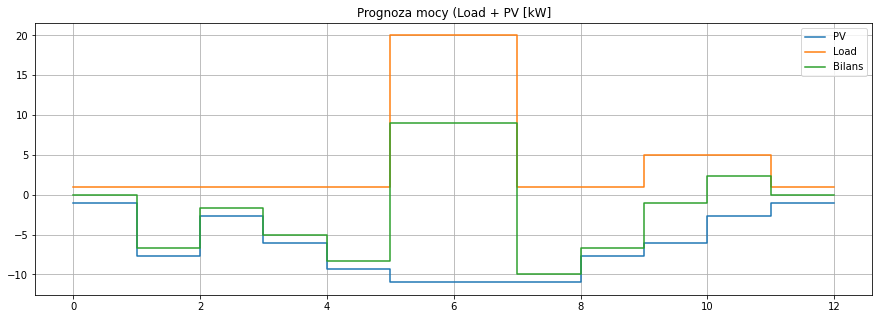

In [3]:
# PV:
pPV = np.array([0,0, 4, 1, 3, 5, 6, 6, 6, 4, 3, 1, 0])*(np.random.rand(1)/0.5)+1  # [kWh], prognoza generacji słonecznej

# Load:
pLoad = [1,1,1,1,1,1,20,20,1,1,5,5,1] # [kW], prognoza obciążenia

fig, ax = plt.subplots(figsize=(15,5))
ax.step(x,-pPV, label='PV')
ax.step(x,pLoad, label='Load')
ax.step(x,pLoad-pPV, label='Bilans')
plt.title('Prognoza mocy (Load + PV [kW]')
plt.grid(True)

leg = ax.legend();

## Całkowity koszt energii elektrycznej:

In [4]:
koszt=np.zeros(12) #utworzenie zerowej tablicy do przechwywania kosztu energii
bilansLoadPV=pLoad-pPV #tablica przechowując bilans energii obejmujący prognozy odbiorników oraz PV

for i in range(0,12): # wyliczenie kosztów energii, w zależności od tego czy prognoza wskazuje na zakup czy jej sprzedaż
    if bilansLoadPV[i]>0:
        koszt[i]=round(bilansLoadPV[i]*cDSOz[i],2)
    else:
        koszt[i]=round(bilansLoadPV[i]*cDSOs[i],2)

print("Koszt/h [PLN]: ",koszt)

kosztAcu = np.zeros(12)
kosztAcu[0]=koszt[0]
for i in range(1,12): # licznik energii
    kosztAcu[i] = round(kosztAcu[i-1] + koszt[i],2)

print("Koszt/12h [PLN]: ",kosztAcu[-1])

Koszt/h [PLN]:  [  0.     0.    -8.01  -5.01  -4.01  -4.17   8.98   8.98 -19.03 -22.71
  -1.06   5.13]
Koszt/12h [PLN]:  -40.91


## Model zasobnika bateryjnego:

In [5]:
# Zasobnik 1 bateryjny
eBateriaN = 13.5  # [kWh], energia znamionowa baterii
pBateriaIn = -5.0  # [kW], moc znamionowa (maksymalna) zwrotu energii do sieci z baterii (rozładowywania baterii)
pBateriaOut = 5.0  # [kW], moc znamionowa (maksymalna) poboru energii z sieci (ładowania baterii)
pBaterii = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] #[kW], moc baterii wypełniona wartościami startowymi, to ten element podlega optymalizacji
eBateriiStart = 0 #[kW], poziom startowy naładowania baterii
peakHoursDemandLimit = 15  # kW, wartość mocy (przyłączeniowej) powyżej, której naliczane są karne koszty za pobór energii (w ramach tzw. peak shaving)
peakHoursPriceCoef = 15  # [ ], współczynnik określający koszt za przekroczenie 'peakHourDemandLimit'

## Algorytm pracy zasobnika bateryjnego:

In [ ]:
""""
1. Wyznaczyć funkcję celu do optymalizacji kosztu opłat za energię elektryczną
2. Sformułować ogranicznia: 
    - chwilowa moc baterii nie może przekroczyć jej mocy znamionowej
    - moc ładowania/rozładowania nie może przekroczyć parametrów znamionowych
    - energia baterii musi zawierać się w granicach [0, Enom]
3. Zastosować metodę optymalizacji np. 'SLSQP'z biblioteki Scipy.optimize
4. Ocenić jakość uzyskanego rozwiązania